# Hospital ward dynamic contact network

Notebook permettant d'analyser le graphe de contacts entre le personnel soignant, administratif et les patients d'un service hospitalier.

## Chargement et préparation des données

In [35]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


df = pd.read_csv("../data/detailed_list_of_contacts_Hospital.dat", delimiter="\t", header=None)

df.head()

,0,1,2,3,4
0,140,1157,1232,MED,ADM
1,160,1157,1191,MED,MED
2,500,1157,1159,MED,MED
3,520,1157,1159,MED,MED
4,560,1159,1191,MED,MED


### Graphe simple
Une seule arête entre les noeuds mais pondérée par la somme des durées des contacts entre les noeuds

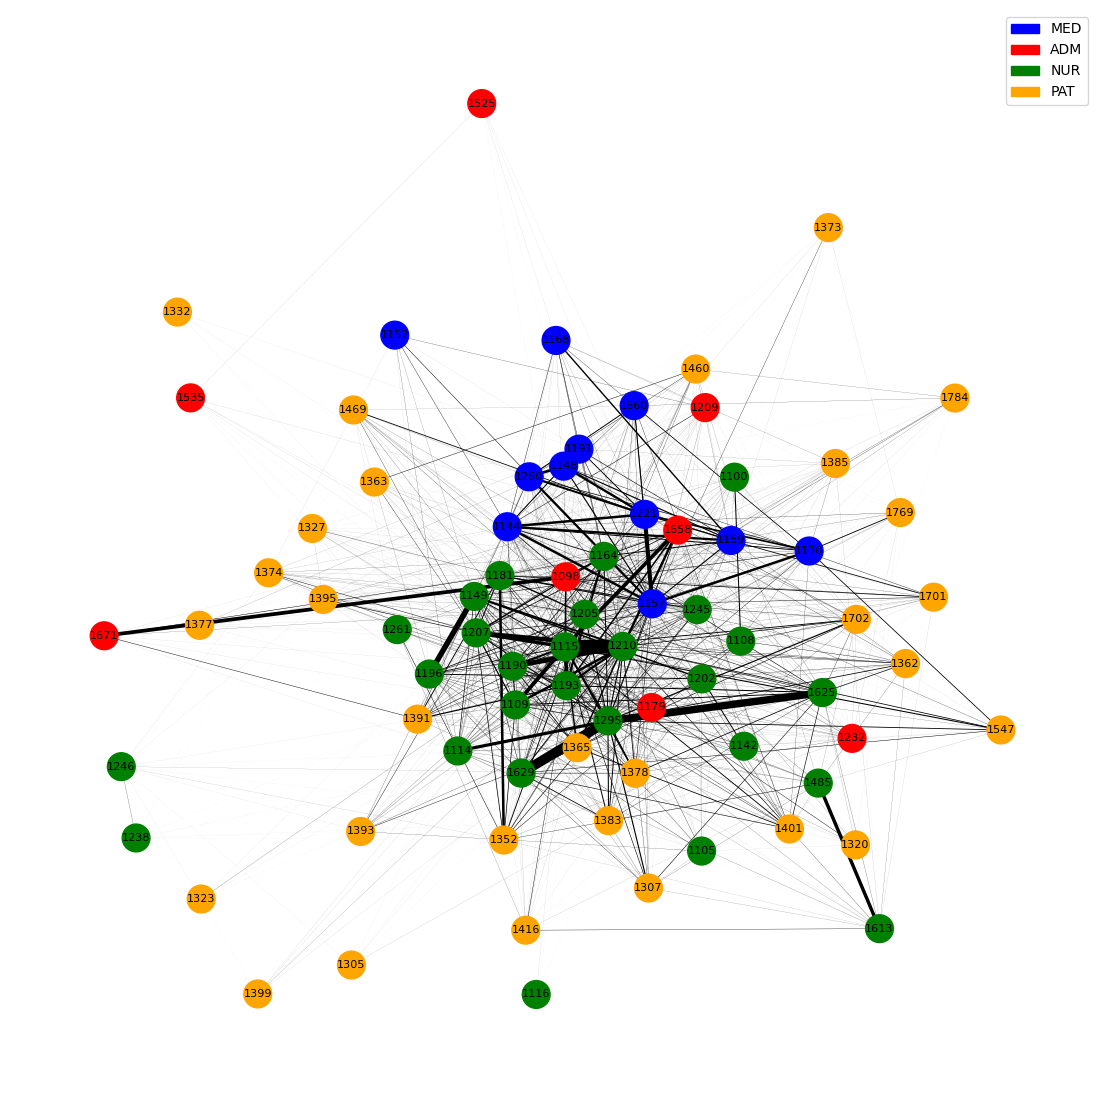

In [16]:
# Simple weighted Graph

G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    
    Si = group[3].iloc[0]   # catégorie du noeud i
    Sj = group[4].iloc[0]   # catégorie du noeud j

    # Ajouter les noeuds
    G.add_node(i, category=Si)
    G.add_node(j, category=Sj)

    # Somme des temps de contact
    total_t = group[0].sum()

    # Ajouter l'arête pondérée
    G.add_edge(i, j, t=total_t)


# Plot d'un premier graphe pondéré

# Couleurs des noeuds des différentes catégories
color_map = {
    "MED": "blue",
    "ADM": "red",
    "NUR": "green",
    "PAT": "orange"
}

node_colors = [color_map[G.nodes[n]["category"]] for n in G.nodes()]

plt.figure(figsize=(14, 14))

# Ajout de la légende
legend_handles = [mpatches.Patch(color=color, label=cat) 
                  for cat, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best")

# Normalisation pour affichage des arêtes pondérées
edges = G.edges()
edge_weights = [G[u][v]["t"] for u, v in edges]
max_w = max(edge_weights)
edge_widths = [10 * (w / max_w) for w in edge_weights] 


# Génération du graphe
nx.draw(
    G,
    with_labels=True,
    node_color=node_colors,
    node_size=400,
    width=edge_widths,
    font_size=8
)

plt.show()

## Analyse

### Première propriétés basiques

#### Distribution des degrés

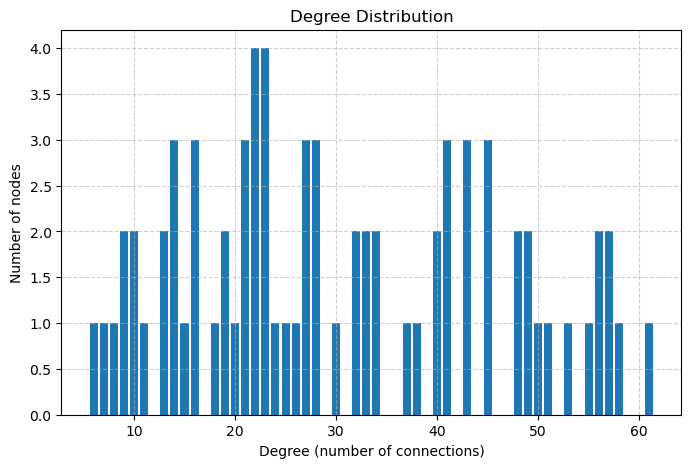

In [5]:
# calcul des degrés de chaque noeud
degrees = [d for n, d in G.degree()]

# Plot de l'hhistogramme des degres
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8)

plt.title("Degree Distribution")
plt.xlabel("Degree (number of connections)")
plt.ylabel("Number of nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

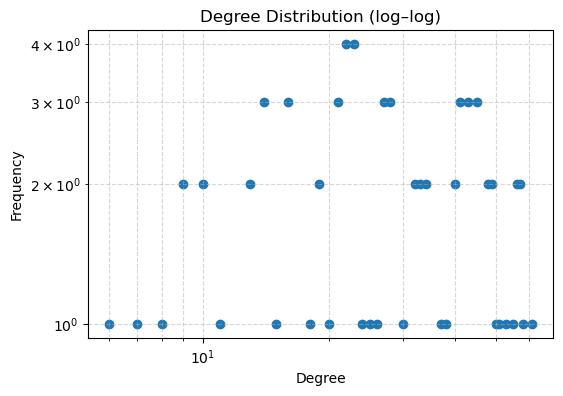

In [6]:
# Création du log/log plot pour estimer si il s'agit d'une distribution en power law
import numpy as np

degree_count = {}
for d in degrees:
    degree_count[d] = degree_count.get(d, 0) + 1

x = np.array(list(degree_count.keys()))
y = np.array(list(degree_count.values()))

plt.figure(figsize=(6, 4))
plt.scatter(x, y)
plt.xscale("log")
plt.yscale("log")
plt.title("Degree Distribution (log–log)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.show()

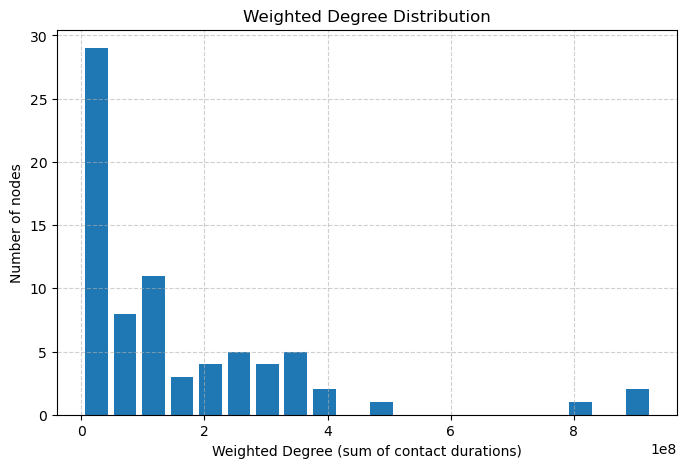

In [ ]:
# Calcul du degree pondéré (somme des 't' pour chaque noeud)
weighted_degrees = [d for n, d in G.degree(weight="t")]

plt.figure(figsize=(8, 5))
plt.hist(weighted_degrees, bins=20, rwidth=0.8)

plt.title("Weighted Degree Distribution")
plt.xlabel("Weighted Degree (sum of contact durations)")
plt.ylabel("Number of nodes")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

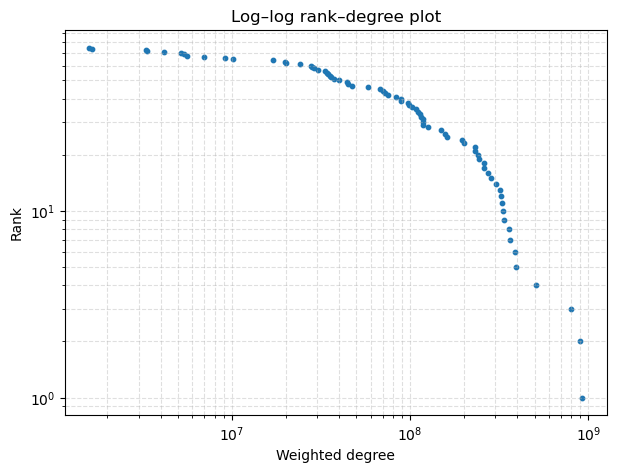

In [ ]:

weighted_degrees_sorted = np.sort(weighted_degrees)[::-1]
ranks = np.arange(1, len(weighted_degrees_sorted) + 1)

plt.figure(figsize=(7,5))
plt.scatter(weighted_degrees_sorted, ranks, s=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Weighted degree")
plt.ylabel("Rank")
plt.title("Log–log rank–degree plot")
plt.grid(True, which="both", linestyle='--', alpha=0.4)
plt.show()

#### Coeffcient de Clustering

In [20]:
# clustering non pondéré moyen
avg_clust = nx.average_clustering(G)
print("Average clustering (unweighted) :", avg_clust)

# clustering pondéré moyen
avg_clust_w = nx.average_clustering(G, weight="t")
print("Average clustering (weighted, weight='t') :", avg_clust_w)

# Local clustering coefficients (non pondéré)
clust_nodes = nx.clustering(G) 

# Local clustering coefficients (pondéré)
clust_nodes_w = nx.clustering(G, weight="t")

nx.set_node_attributes(G, clust_nodes, "clustering")
nx.set_node_attributes(G, clust_nodes_w, "clustering_w")

# Récupérer category pour chaque noeud
cat = nx.get_node_attributes(G, "category")

# Construction dataframe
dfc = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [cat[n] for n in G.nodes()],
    "clustering": [clust_nodes[n] for n in G.nodes()],
    "clustering_w": [clust_nodes_w[n] for n in G.nodes()]
})

# Moyennes par catégorie
by_cat = dfc.groupby("category").agg({
    "clustering": ["mean", "median", "count"],
    "clustering_w": ["mean", "median"]
})
print(by_cat)

Average clustering (unweighted) : 0.6402796539914468
Average clustering (weighted, weight='t') : 0.006451516102032426
         clustering                 clustering_w          
               mean    median count         mean    median
category                                                  
ADM        0.701624  0.734392     8     0.005737  0.004285
MED        0.655725  0.641536    11     0.007910  0.008021
NUR        0.548132  0.558405    27     0.006634  0.006322
PAT        0.703291  0.707510    29     0.005925  0.004618


#### Centralité

In [28]:
# --- Centralités pondérées ---
degree = dict(G.degree(weight="t"))

betw = nx.betweenness_centrality(G, weight="t", normalized=True)

# closeness → distance = 1 / poids
#  pour que "plus de contact = distance plus courte", on inverse)
G_for_closeness = G.copy()
for u, v, d in G_for_closeness.edges(data=True):
    d["inv_t"] = 1 / d["t"]

close = nx.closeness_centrality(G_for_closeness, distance="inv_t")

pagerank = nx.pagerank(G, weight="t")

df_cent = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "degree": [degree[n] for n in G.nodes()],
    "betweenness": [betw[n] for n in G.nodes()],
    "closeness": [close[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
})

df_cent.head()


,node,category,degree,betweenness,closeness,pagerank
0,1098,ADM,286002920,0.170678,3.791363e+06,0.022934
1,1100,NUR,44360820,0.023325,2.299782e+06,0.005728
2,1105,NUR,33259000,0.048871,2.337836e+06,0.004512
3,1108,NUR,74801660,0.000000,2.593131e+06,0.008358
4,1109,NUR,317852560,0.001851,3.997218e+06,0.023498


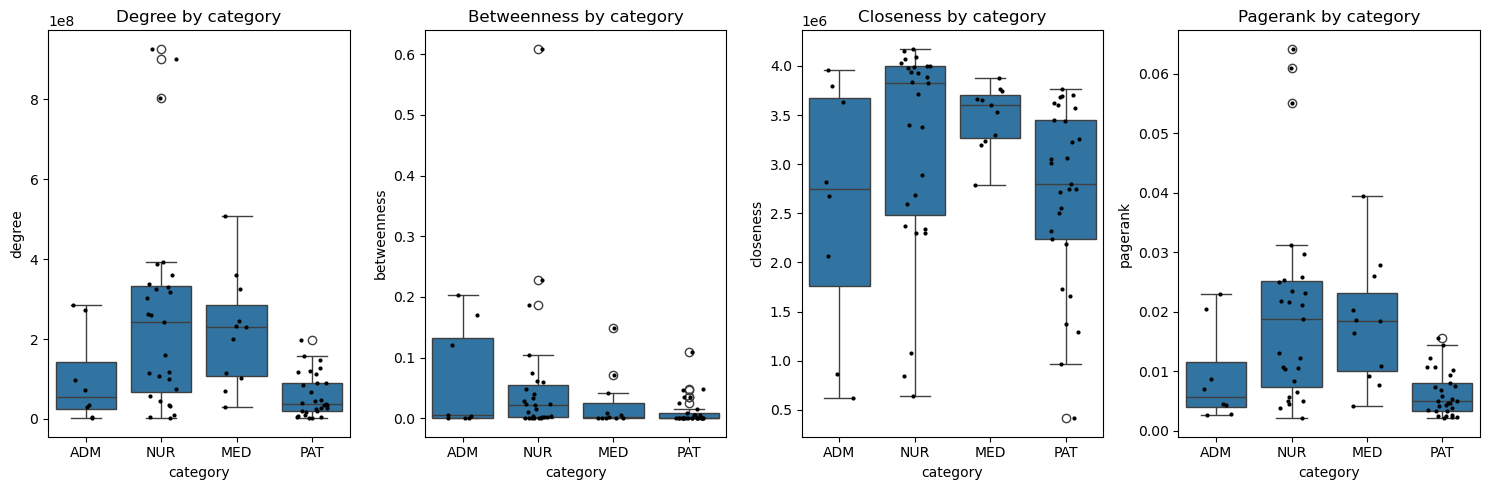

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

centralities = ["degree", "betweenness", "closeness", "pagerank"]

plt.figure(figsize=(15, 5))
for i, c in enumerate(centralities, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=df_cent, x="category", y=c)
    sns.stripplot(data=df_cent, x="category", y=c, color="black", size=3, jitter=0.2)
    plt.title(f"{c.capitalize()} by category")
plt.tight_layout()
plt.show()

### Modèles de réseau


=== Comparaison avec modèle Erdős–Rényi ===


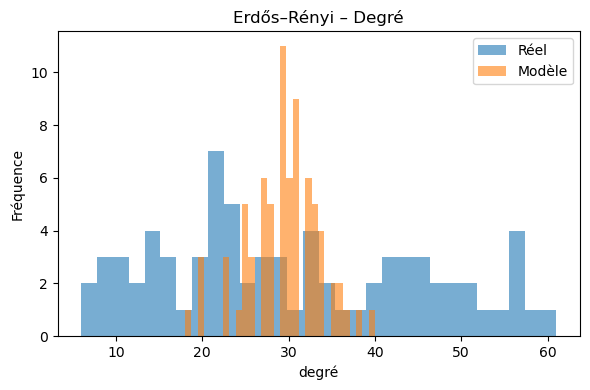

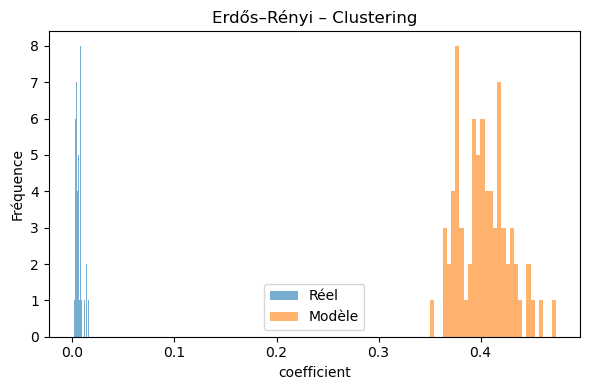

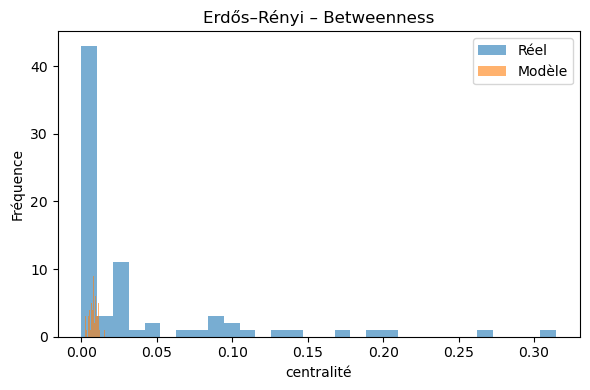

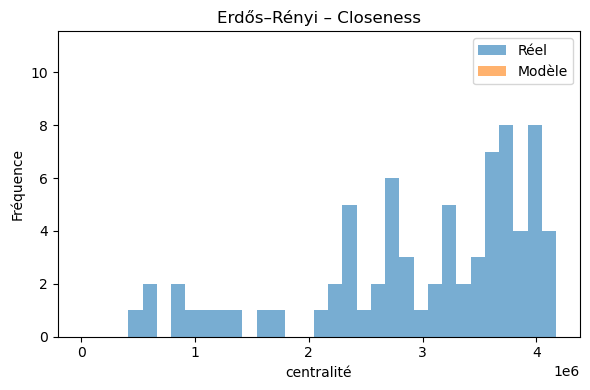


=== Comparaison avec modèle Configuration Model ===


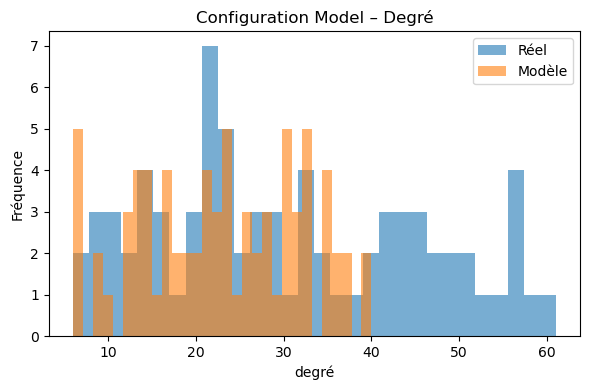

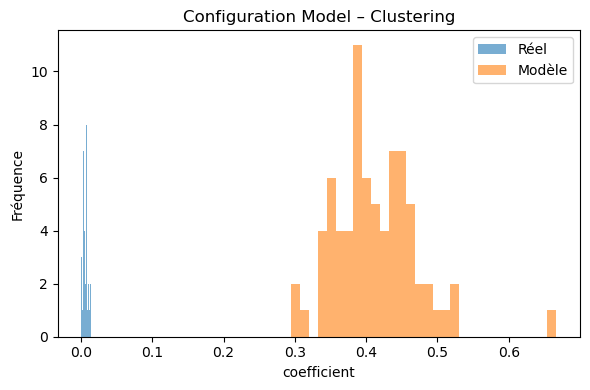

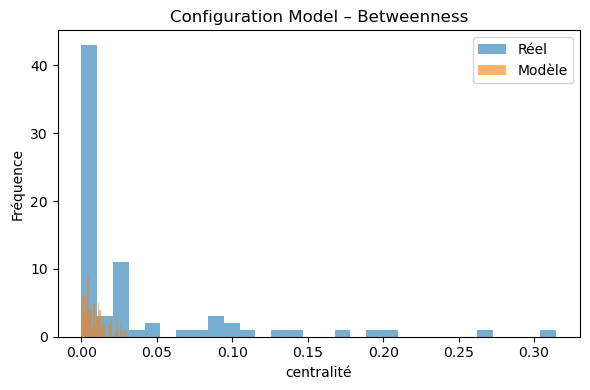

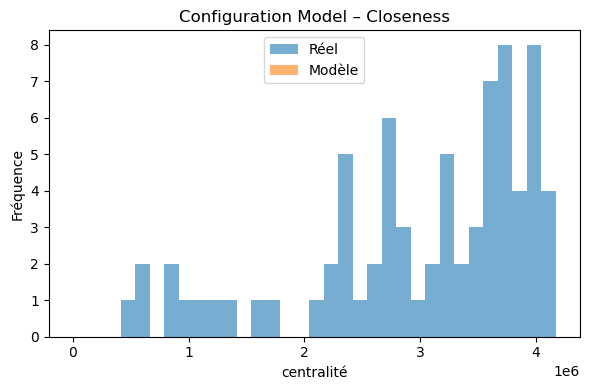


=== Comparaison avec modèle Barabási–Albert ===


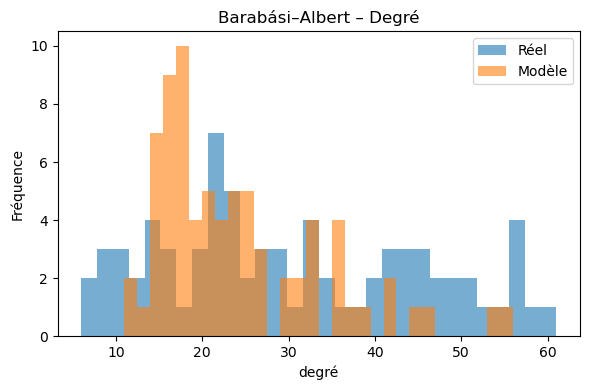

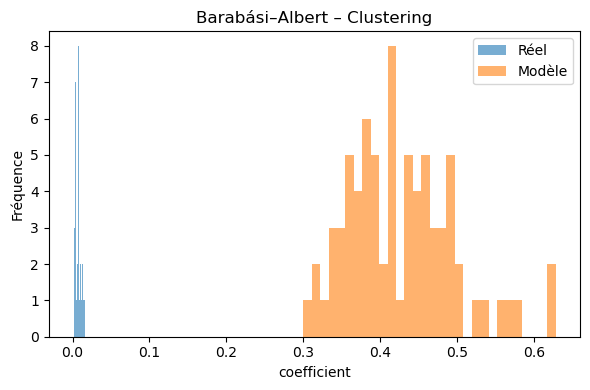

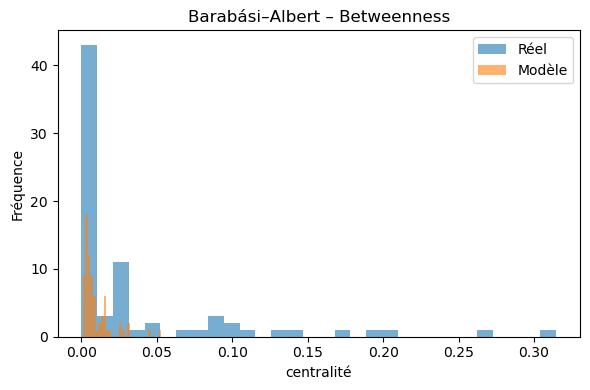

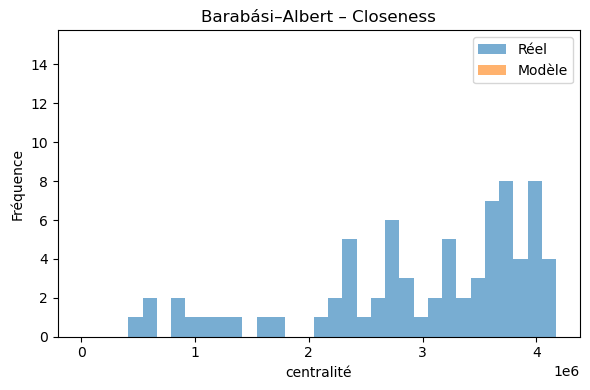

In [ ]:

# -------------------------------------------------------------------
# Helper: plotting distributions
# -------------------------------------------------------------------
def plot_distribution(data_real, data_model, title, xlabel):
    plt.figure(figsize=(6,4))
    plt.hist(data_real, bins=30, alpha=0.6, label='Réel')
    plt.hist(data_model, bins=30, alpha=0.6, label='Modèle')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Fréquence")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# Helper: compute metrics for a graph
# -------------------------------------------------------------------
def compute_metrics(G):
    metrics = {}

    # Degree
    metrics["degree"] = [d for _, d in G.degree()]

    # Weighted degree (sum of weights)
    if nx.get_edge_attributes(G, "t"):
        metrics["weighted_degree"] = [sum(d["t"] for _, _, d in G.edges(n, data=True)) for n in G.nodes()]
    else:
        metrics["weighted_degree"] = None

    # Clustering
    metrics["clustering"] = list(nx.clustering(G, weight="t").values())

    # Betweenness
    metrics["betweenness"] = list(nx.betweenness_centrality(G, weight="inv_t").values()) \
        if nx.get_edge_attributes(G, "inv_t") else list(nx.betweenness_centrality(G).values())

    # Closeness
    metrics["closeness"] = list(nx.closeness_centrality(G, distance="inv_t").values()) \
        if nx.get_edge_attributes(G, "inv_t") else list(nx.closeness_centrality(G).values())

    # PageRank
    metrics["pagerank"] = list(nx.pagerank(G, weight="t").values()) \
        if nx.get_edge_attributes(G, "t") else list(nx.pagerank(G).values())

    # Edge weights
    metrics["weights"] = [d["t"] for _,_,d in G.edges(data=True)] \
        if nx.get_edge_attributes(G, "t") else None

    return metrics


# Ajoute des distances inverses pour pondérer les centralités
for u,v,d in G.edges(data=True):
    if d["t"] > 0:
        d["inv_t"] = 1/d["t"]
    else:
        d["inv_t"] = 0.000001

metrics_real = compute_metrics(G)

# -------------------------------------------------------------------
# 2. Generate comparable random models
# -------------------------------------------------------------------
n = G.number_of_nodes()
m = G.number_of_edges()

# --- Erdős–Rényi ---
p = (2*m) / (n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

# --- Configuration model (preserves degree sequence) ---
degree_seq = [d for _, d in G.degree()]
G_cfg_multi = nx.configuration_model(degree_seq)
G_cfg = nx.Graph(G_cfg_multi)   # remove parallel edges
G_cfg.remove_edges_from(nx.selfloop_edges(G_cfg))

# --- Preferential attachment (Barabási–Albert) ---
avg_degree = int(np.mean(degree_seq)//2) 
avg_degree = max(1, avg_degree)
G_ba = nx.barabasi_albert_graph(n, avg_degree)

# -------------------------------------------------------------------
# 3. Compute metrics for all models
# -------------------------------------------------------------------
metrics_er  = compute_metrics(G_er)
metrics_cfg = compute_metrics(G_cfg)
metrics_ba  = compute_metrics(G_ba)

# -------------------------------------------------------------------
# 4. Plot comparisons
# -------------------------------------------------------------------
def compare_model(metrics_real, metrics_model, model_name):
    print(f"\n=== Comparaison avec modèle {model_name} ===")

    plot_distribution(metrics_real["degree"], metrics_model["degree"],
                      f"{model_name} – Degré", "degré")

    if metrics_real["clustering"] and metrics_model["clustering"]:
        plot_distribution(metrics_real["clustering"], metrics_model["clustering"],
                          f"{model_name} – Clustering", "coefficient")

    plot_distribution(metrics_real["betweenness"], metrics_model["betweenness"],
                      f"{model_name} – Betweenness", "centralité")

    plot_distribution(metrics_real["closeness"], metrics_model["closeness"],
                      f"{model_name} – Closeness", "centralité")

    if metrics_real["weights"] and metrics_model["weights"]:
        plot_distribution(metrics_real["weights"], metrics_model["weights"],
                          f"{model_name} – Distribution des poids", "poids")

# -------------------------------------------------------------------
# 5. RUN ALL COMPARISONS
# -------------------------------------------------------------------
compare_model(metrics_real, metrics_er,  "Erdős–Rényi")
compare_model(metrics_real, metrics_cfg, "Configuration Model")
compare_model(metrics_real, metrics_ba,  "Barabási–Albert")


### Détection de communautés

In [36]:
from networkx.algorithms.community import spectral_modularity

communities = spectral_modularity(G, weight="t")

# communities est une liste de sets de noeuds
for idx, com in enumerate(communities):
    print(f"Communauté {idx+1}: {len(com)} nœuds")

ImportError: cannot import name 'spectral_modularity' from 'networkx.algorithms.community' (/opt/anaconda3/envs/master_ds/lib/python3.13/site-packages/networkx/algorithms/community/__init__.py)

In [ ]:
import community as community_louvain

partition = community_louvain.best_partition(G, weight="t")

for node, comm in partition.items():
    print(node, "-->", comm)

1098 --> 0
1100 --> 1
1105 --> 2
1108 --> 1
1109 --> 3
1114 --> 1
1115 --> 3
1116 --> 3
1130 --> 4
1142 --> 2
1144 --> 4
1148 --> 4
1149 --> 2
1152 --> 4
1157 --> 4
1159 --> 4
1164 --> 0
1168 --> 4
1179 --> 3
1181 --> 0
1190 --> 3
1191 --> 4
1193 --> 3
1196 --> 2
1202 --> 2
1205 --> 0
1207 --> 3
1209 --> 4
1210 --> 3
1221 --> 4
1232 --> 0
1245 --> 0
1260 --> 4
1261 --> 0
1295 --> 1
1320 --> 3
1327 --> 0
1332 --> 4
1352 --> 0
1362 --> 1
1365 --> 3
1373 --> 4
1374 --> 3
1377 --> 0
1378 --> 1
1383 --> 1
1391 --> 0
1393 --> 3
1395 --> 3
1401 --> 3
1416 --> 5
1460 --> 0
1525 --> 0
1547 --> 3
1625 --> 1
1629 --> 1
1658 --> 3
1660 --> 4
1671 --> 0
1701 --> 4
1702 --> 1
1769 --> 4
1385 --> 4
1307 --> 1
1363 --> 0
1246 --> 0
1305 --> 1
1399 --> 3
1469 --> 4
1535 --> 0
1323 --> 3
1485 --> 5
1784 --> 0
1238 --> 0
1613 --> 5


In [38]:
mod = community_louvain.modularity(partition, G, weight="t")
print("Modularité =", mod)

Modularité = 0.3724323400770911


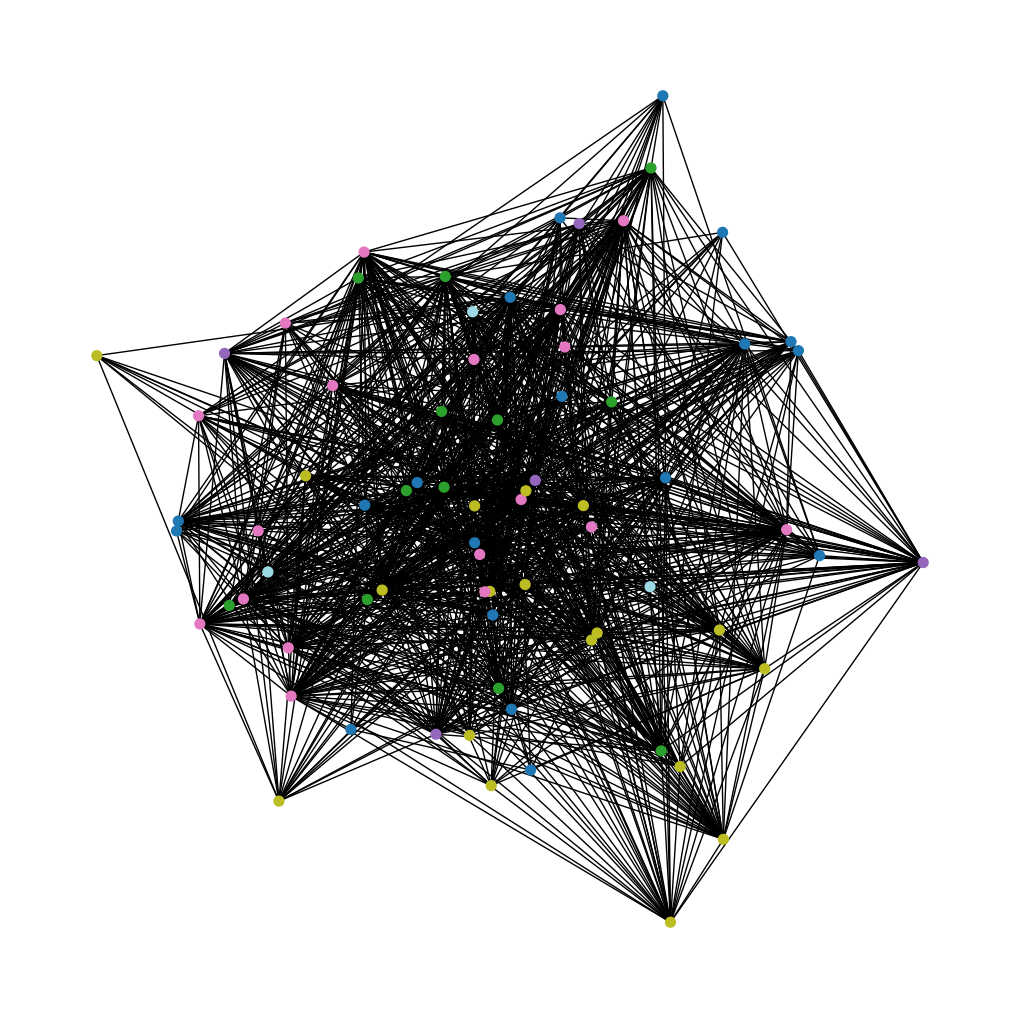

In [39]:
pos = nx.spring_layout(G, weight="t")

# couleur = indice de communauté
colors = [partition[n] for n in G.nodes()]

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab20, 
        with_labels=False, node_size=50)

plt.show()

In [40]:
from collections import Counter, defaultdict

comm_to_nodes = defaultdict(list)
for node, com in partition.items():
    comm_to_nodes[com].append(node)

for com, nodes in comm_to_nodes.items():
    cats = [G.nodes[n]["category"] for n in nodes]
    print(f"Communauté {com} ({len(nodes)} nœuds) :")
    print(Counter(cats))
    print()

Communauté 0 (19 nœuds) :
Counter({'NUR': 7, 'PAT': 7, 'ADM': 5})

Communauté 1 (12 nœuds) :
Counter({'NUR': 6, 'PAT': 6})

Communauté 2 (5 nœuds) :
Counter({'NUR': 5})

Communauté 3 (18 nœuds) :
Counter({'PAT': 9, 'NUR': 7, 'ADM': 2})

Communauté 4 (18 nœuds) :
Counter({'MED': 11, 'PAT': 6, 'ADM': 1})

Communauté 5 (3 nœuds) :
Counter({'NUR': 2, 'PAT': 1})



/var/folders/v6/jw_h5hc942x92sl7jhfcmctm0000gn/T/ipykernel_19240/1118578342.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20")


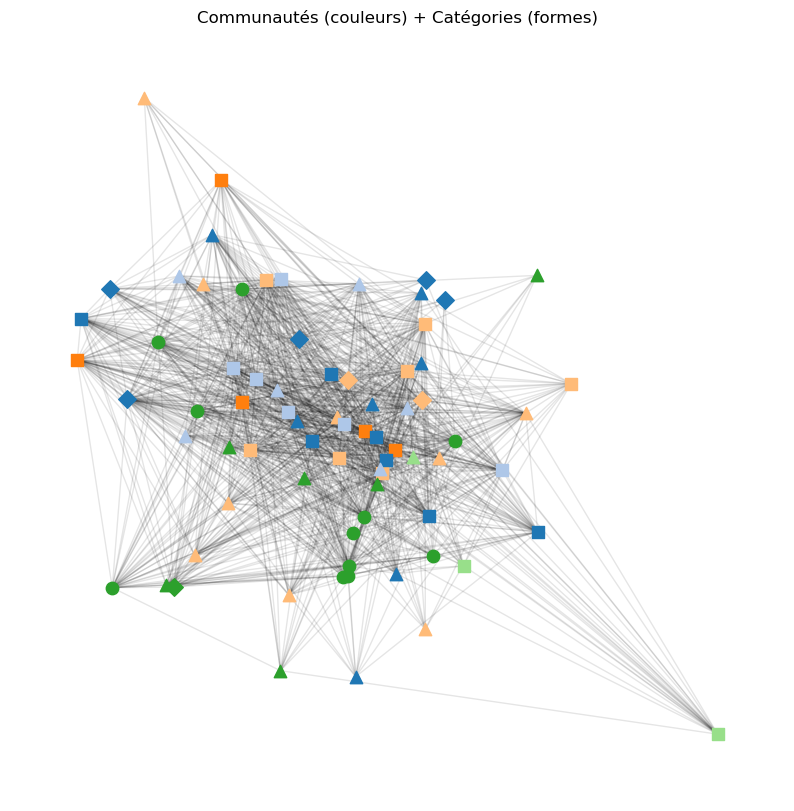

In [41]:
# Position des nœuds
pos = nx.spring_layout(G, weight="t", seed=42)

# Palette de couleurs pour les communautés
import matplotlib.cm as cm
cmap = cm.get_cmap("tab20")

# Formes selon catégorie
shapes = {
    "MED": "o",
    "NUR": "s",
    "ADM": "D",
    "PAT": "^"
}

# Dessin
plt.figure(figsize=(10, 10))

for node in G.nodes():
    com = partition[node]  # communauté Louvain
    cat = G.nodes[node]["category"]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[node],
        node_color=[cmap(com)],
        node_shape=shapes.get(cat, "o"),
        label=cat,
        node_size=80
    )

nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.title("Communautés (couleurs) + Catégories (formes)")
plt.axis("off")
plt.show()

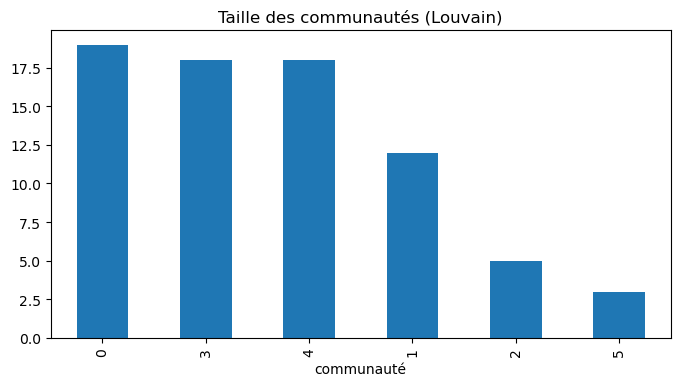

In [43]:
com_sizes = Counter(partition.values())

df_sizes = pd.DataFrame({
    "communauté": list(com_sizes.keys()),
    "taille": list(com_sizes.values())
}).sort_values("taille", ascending=False)

df_sizes.plot.bar(x="communauté", y="taille", figsize=(8,4), legend=False)
plt.title("Taille des communautés (Louvain)")
plt.show()